# Homework 5
Pedro Augusto Januzzi Guerra

# Questions

1. Use the finite element methods to solve an individual's optimal policy function for next period assets, $a_{t+1}:

\begin{align*}
    \max &\mathbb{E}_0\sum_{t=0}^\infty \beta^t[c_t^{1-\mu}-1]/(1-\mu)\\
    \text{s.t.} &c_t+a_{t+1} = wl_t + (1+r)a_t\\
    & c_t \geq 0, a_t\geq 0
\end{align*}
where $l_t$ is assumed to be iid and well approximated by a Markov chain. Assume the individual takes prices $w$ and $r$ as given.

2. Solve for the general equilibrium prices assuming the aggregate production function is Cobb-Douglas in capital and labor. How do aggregate saving rates and equilibrium interest rates vary as you vary $\mu$ and the properties of the Markov chain on $l_t$? Interpret the results.

3. (Optional) Compare what you find in question 2 to Table I results in Aiyagari (1994).

---
As I did in Homework 4, I'll solve the problem using the Galerkin Method. Now, we have to solve an Aiyagari model. To that goal, I used the same sources cited in Homework 4 and the paper "Uninsured Idiosyncratic Risk and Aggregate Saving", written by Rao Aiyagari (1994). I also used Aiyagari (1993a), which has the same title as Aiyagari (1994), but has more details on the computational of the model

I abstract from a detailed explanation on finite element methods as I've already done this in Homework 4.

---
### Question 1
We have a model where agents are heterogenous with respect to labor endowment. Those agents can invest in a unique asset and, since there is uncertainty, this means that they cannot fully insure against risks. Hence, we have an incomplete markets heterogenous agents model. 

The process for labor is assumed to be i.i.d and is well approximated by a Markov chain. We also assume a perfect competitive market, so agents take interest rates, $r$, and wages, $w$, as given.

Packages used:

In [1]:
# Packages used
using LinearAlgebra, Plots, Distributions, PrettyTables, NLsolve, ForwardDiff

First, let's find a Markov chain that determines that transition probabilities of labor endowment. In Homework 4, uncertainty took place in form of TFP shocks that followed an AR(1) process. Since there was some persistence in this process, TFP shocks were not i.i.d.. In question 2, it's asked to change the properties of the Markov chain on $l_t$. Hence, I will create a funcion that generates a transition matrix and grid for labor endowments. For now, since we assume that labor endowments are i.i.d, I'll assume that labor follows an AR(1) process with $\rho=0$, which implies that $$l_t = \varepsilon_t, \hspace{3mm}\varepsilon_t\overset{iid}{\sim} N(0,\sigma^2)$$ Since the labor realizations are iid, it means that all entries in the transition matrix should be equal. In question 2, I'll assume that $\rho > 0$, which is one way to change the properties of the Markov chain, and check how the results change.

In [2]:
function Tauchen(sigma, mu, pts, rho)
    scale = 1;  # scale parameter
    upper_bound = scale*sigma/sqrt(1 - rho^2); # note this is the same as in hw 4, but in this question rho=0
    lower_bound = -upper_bound;
    grid_l = LinRange(lower_bound, upper_bound, pts);

    delta_l = (upper_bound - lower_bound) / (pts - 1)
    P = zeros(pts, pts)
    dist = Normal(mu, sigma)

    for i = 1:pts
        P[i,1] = cdf(dist, (grid_l[1] - (1 - rho) * mu .- rho * grid_l[i] + delta_l / 2))
        P[i, end] = 1 - cdf(dist, (grid_l[end] - (1 - rho) * mu - rho * grid_l[i] - delta_l / 2))

        for j = 2:(pts-1)
            P[i,j] = cdf(dist, (grid_l[j] + delta_l / 2 - (1 - rho) * mu - rho * grid_l[i])) -
                        cdf(dist, (grid_l[j] - delta_l / 2 - (1 - rho) * mu - rho * grid_l[i]))
        end
    end
    grid_l = exp.(grid_l);

    if rho == 0
        grid_l = LinRange(0.3,1,pts);
        P = ones(pts,pts)/pts;
    end

    return P, grid_l
end

Tauchen (generic function with 1 method)

Set parameter values:

In [3]:
σ = 0.05;  # st dev of shocks
mean = 0;   # mean of shocks
N = 5;  # number of grid points
ρ_1 = 0; # persistence for question 1

# For question 1, I consider a linearly spaced grid between 0.3 and 1 in which probabilities are the same.
# Compute transition matrix and grid for labor
T, l_grid = Tauchen(σ,mean,N,ρ_1);

In [4]:
# Setting a table 
pretty_table(round.(l_grid';digits=4); header = ["$i" for i = 1:N],
            title = "Grid of labor endowments",
            border_crayon = crayon"bold yellow",
            tf = tf_simple)

println("-"^70)  # separator = 70 dashes

pretty_table(round.(T;digits=4); header = ["$i" for i = 1:N],
            title = "Transition Matrix via Tauchen's Method",
            row_labels = ["$x" for x = 1:N],
            border_crayon = crayon"bold yellow",
            tf = tf_simple)

Grid of labor endowments
====== ======= ====== ======= ======
    1       2      3       4     5  
====== ======= ====== ======= ======
  0.3   0.475   0.65   0.825   1.0  
====== ======= ====== ======= ======
----------------------------------------------------------------------
Transition Matrix via Tauchen's Method
==== ===== ===== ===== ===== ======
        1     2     3     4     5  
==== ===== ===== ===== ===== ======
  1   0.2   0.2   0.2   0.2   0.2  
  2   0.2   0.2   0.2   0.2   0.2  
  3   0.2   0.2   0.2   0.2   0.2  
  4   0.2   0.2   0.2   0.2   0.2  
  5   0.2   0.2   0.2   0.2   0.2  
==== ===== ===== ===== ===== ======


Note there is a constraint on investment. In Aiyagari (1994), the author defines $$\phi = \min\Big\{b,\frac{wl_t}{r}\Big\}$$ where $b$ is some arbitrary parameter and $\frac{wl_t}{r}$ is the natural borrowing limit. The constraint then is $a_t \geq -\phi$. In our question, $b=0$ and, since $w$ and $r$ will be fixed objects in the stationary equilibrium and $l_t$ doesn't assume negative values, it follows that $\phi=0$.

Moreover, Aiyagari defines $\hat{a}_t = a_t + \phi$ and $z_t = wl_t + (1+r)\hat{a}_t - r\phi$, where $z_t$ represents the total amount of resources available to the agent (cash-in-hand), so that the new budget constraint is given by $$c_t + \hat{a}_{t+1} = z_t$$

Note that, since in our example $\phi=0$, this doesn't make a difference, but if $\phi$ was greater than one, this transformation would indeed be useful.

As advised during the lecture, I will use a penalty function to implement the constraint. Therefore, the problem can be redefined as follows: 

\begin{align*}
 &\mathbb{E}_0 \sum_{t=0}^\infty \beta^t\Bigg[\frac{(z_t-\hat{a}_{t+1})^{1-\mu} - 1}{1-\mu} + \frac{\gamma}{3}\min(\hat{a}_{t+1},\phi)^3\Bigg]\\[3pt] &\text{s.t.}\hspace{2mm} z_t = wl_t+(1+r)\hat{a}_t - r\phi \hspace{2mm} \forall t
\end{align*}

whose FOC wrt $\hat{a}_{t+1}$ is $$(z_t-\hat{a}_{t+1})^{-\mu} - \gamma\min(\hat{a}_{t+1},0)^2 = (1+r)\beta\sum_{s_{t+1}}\pi(s_{t+1})(z_{t+1}-\hat{a}_{t+2})^{-\mu}$$

where I used $\phi=0$. 

Note this is essentially the formula that Ellen wrote on the board.

Our goal is to find an approximation for the policy function of savings using the same piecewise linear function as used in Hw 4: $$\hat{a}(z,s) = \sum_{i=1}^n \theta_i\psi_i(z)$$ where 
$$    
\psi_i(z) = 
\begin{cases} 
\frac{z - z_{i-1}}{z_i - z_{i-1}} & \text{if } z \in [z_{i-1}, z_i] \\ 
\frac{z_{i+1} - z}{z_{i+1} - z_i} & \text{if } z \in [z_i, z_{i+1}] \\ 
0 & \text{elsewhere}
\end{cases}
$$

As in the previous homework, we need to find optimal $\theta$'s, in the sense of generating a good approximation for our savings' policy function, that is, our residual is sufficiently small. The residual function is given by: $$R(z,s,\theta)=(z-\hat{a}')^{-\mu}-\gamma\min(\hat{a}',0)^2 - (1+r)\beta\sum_{s'}\pi(s')(z'-\hat{a}'')^{-\mu}$$

The Galerkin method chooses $\theta$'s so that $$\int_{z_1}^{z_n} R(z,s;\theta)\psi_i(z)\omega(z)dz=0\hspace{3mm}\forall i=1,...,n$$ in which $\omega$ is some weighting function.

Let's define some parameters:

In [5]:
β = 0.95; # discount factor
δ = 0.04; # depreciation rate
α = 0.33; # output elasticity of capital:: Cobb-Douglas
μ_1 = 2; # relative risk aversion coefficient
μ = μ_1;
γ = 50000; # parameter for penalty function:::: it's a little of an overkill, could be smaller
ϕ = 0; # borrowing constraint

Note that we still have to find a grid for $a$. I set the lower bound of the grid to be equal to the borrowing limit. The upper bound of the grid was arbitrarily set to be equal to 4, but the code is robust to other values. 

Create grid for assets:

In [6]:
a_lb = ϕ;
a_ub = 4;
n = 20;
a_grid = LinRange(a_lb,a_ub,n);

# Values for prices (guesses)
r_max = (1/β)-1; # maximum interest rate
r_g = 0.8*r_max; # guess for interest rate
w_g = (1-α)*(α/(r_g+δ))^(α/(1-α)); # guess for wage

Define functions:

In [7]:
# Psi function::: same idea as HW 4
function psi(i,a,grid_a)
    n = length(grid_a);
    if i == 1
        if a >= grid_a[i] && grid_a[i+1] >= a
            ψ = (grid_a[i+1] - a)/(grid_a[i+1] - grid_a[i]);
        else        
            ψ = 0;
        end
        
    elseif i == n   
        if a >= grid_a[i-1] && grid_a[i] >= a    
            ψ = (a - grid_a[i-1])/(grid_a[i] - grid_a[i-1]);
        else        
            ψ = 0;        
        end
        
    else        
        if a >= grid_a[i-1] && grid_a[i] >= a            
            ψ = (a - grid_a[i-1])/(grid_a[i] - grid_a[i-1]);            
        elseif a > grid_a[i] && grid_a[i+1] >= a
            ψ = (grid_a[i+1] - a)/(grid_a[i+1] - grid_a[i]);           
        else 
            ψ = 0;           
        end        
    end

    return ψ
end

# Function to compute the assets for tomorrow
function asset(θ,x,y)

    idx_labor = findfirst(z -> z == y, l_grid); # get the index (position in the grid) in the of the labor endowment
    
    a = 0;
    for i=1:n
        a += θ[i,idx_labor]*psi(i,x,a_grid) # compute assets for tomorrow using the approximation
    end
   
    return a
 end

 # Function to compute the residual
 function residuals(θ,k,l)

    idx_labor = findfirst(z -> z==l,l_grid);
    c(x,y) = w_g*y + (1+r_g)*x - asset(θ,x,y); # function that computes consumption today
    aux1 = (c(k,l))^(-μ) - γ*min(asset(θ,k,l),0)^2; # first part of residual equation
    aux2 = 0;
    for i=1:N
        aux2 += T[idx_labor,i]*(c(asset(θ,k,l),l_grid[i]))^(-μ); # second part of residual equation
    end
    # Residual
    R = aux1 - β*(1+r_g)*aux2; # residual equation

    return R
 end

# Function to solve the integral using quadratures: credits to Ethan Cohen bc my function was not working
function quadrature(f,start,endd,n)

    d = n-1;
    delta = (endd-start)/(n-1);
    quad_pts = zeros(n);
    quad_wght = zeros(n);
    for i=1:n   
        quad_pts[i] = start + (i-1)*delta;
    end

    quad_wght[1] = delta/2;
    quad_wght[n] = delta/2;
    
    for i=2:d
        quad_wght[i] = delta;
    end

    intt = 0;
    for i=1:n
        intt += quad_wght[i]*f(quad_pts[i]);
    end

    return intt
end

# Function to build the weighted integral:
function weighted_integral(θ,i,j)
    
    sol = quadrature(x -> psi(i,x,a_grid)*residuals(θ,x,l_grid[j]),a_grid[1],a_grid[end],n); # galerkin 

    if sol == -Inf || isnan(sol)
        return -100
    else
        return sol
    end

end

# Function to compute optimal solution for θ using the newton-raphson method: credits to Ethan Cohen
function nrm(G,θ;tol=1e-10,max_iter=40)

    for iter in 1:max_iter

        residual = abs(sum(G(θ)));

        if residual <= tol
            return θ;
        end
   
        J = ForwardDiff.jacobian(G,θ);
        θ = reshape(vec(θ) - inv(J) * vec(G(θ)), n, N);

    end

    if abs(sum(G(θ))) <= tol
        return θ
    elseif abs(sum(G(θ))) > tol
        return θ
    end

end

nrm (generic function with 1 method)

Create a function to compute the optimal $\theta$:

In [8]:
root_fct = θ -> [weighted_integral(θ,i,j) for i in 1:n, j in 1:N]

#27 (generic function with 1 method)

Initial guess for thetas:

In [9]:
θ = zeros(n,N);
for i=1:N
    θ[:,i] = 0.35*(w_g*l_grid[i] .+ (1 + r_g)*a_grid);
end

Solve the system using the initial guess $\theta$:

In [10]:
θ_opt = nrm(root_fct, θ, tol=1e-6);

Compute the policy function:

In [11]:
A_grid = LinRange(0,4,100);
a_policy = zeros(N,length(A_grid));

for i = 1:N
    for j = 1:length(A_grid)
        aux = 0;
        for m = 1:n 
            aux += θ_opt[m,i]*psi(m,A_grid[j],A_grid); 
        end
        a_policy[i,j] = aux;
    end
end

Plot the policy function:

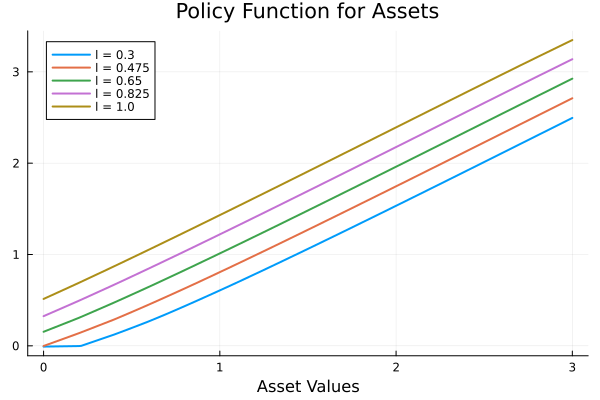

In [12]:
aux = l_grid[1]
plt = plot(x -> asset(θ_opt, x, l_grid[1]), a_lb, 3, label="l = $aux", 
           title="Policy Function for Assets", xlabel="Asset Values", linewidth=2)

for i = 2:length(l_grid)
    aux = l_grid[i]
    plot!(plt, x -> asset(θ_opt, x, l_grid[i]), a_lb, 3, label="l = $aux", linewidth=2)
end

display(plt)

---
### Question 2

Now let's endogenize prices. The idea is the same as before, but now prices will also be arguments in the functions, so the first thing we have to do is to define some new functions:

In [13]:
 # Function to compute the residual
 function residuals(θ,k,l;w,r)

    idx_labor = findfirst(z -> z==l,l_grid);
    c(x,y) = w*y + (1+r)*x - asset(θ,x,y); # function that computes consumption today
    aux1 = (c(k,l))^(-μ) - γ*min(asset(θ,k,l),0)^2; # first part of residual equation
    aux2 = 0;
    for i=1:N
        aux2 += T[idx_labor,i]*(c(asset(θ,k,l),l_grid[i]))^(-μ); # second part of residual equation
    end
    # Residual
    R = aux1 - β*(1+r)*aux2; # residual equation

    return R
 end

# Function to solve the integral using quadratures
function quadrature(f,start,endd,n)

    d = n-1;
    delta = (endd-start)/(n-1);
    quad_pts = zeros(n);
    quad_wght = zeros(n);
    for i=1:n   
        quad_pts[i] = start + (i-1)*delta;
    end

    quad_wght[1] = delta/2;
    quad_wght[n] = delta/2;
    
    for i=2:d
        quad_wght[i] = delta;
    end

    intt = 0;
    for i=1:n
        intt += quad_wght[i]*f(quad_pts[i]);
    end

    return intt
end

# Function to build the weighted integral:
function weighted_integral(θ,i,j;w,r)
    
    sol = quadrature(x -> psi(i,x,a_grid)*residuals(θ,x,l_grid[j];w=w,r=r),a_grid[1],a_grid[end],n); # galerkin 

    if sol == -Inf || isnan(sol)
        return -100
    else
        return sol
    end

end

root_fctnew(θ;w,r) = [weighted_integral(θ,i,j;w=w,r=r) for i in 1:n, j in 1:N]

# Function to compute optimal solution for θ using the newton-raphson method
function nrm(root_fctnew,θ;w,r,tol=1e-10,max_iter=40)

    for iter in 1:max_iter

        residual = abs(sum(root_fctnew(θ;w=w,r=r)));

        if residual <= tol
            return θ;
        end
   
        J = ForwardDiff.jacobian(θ -> root_fctnew(θ;w=w,r=r),θ);
        θ = reshape(vec(θ) - inv(J) * vec(root_fctnew(θ;w=w,r=r)), n, N);

    end

    if abs(sum(root_fctnew(θ;w=w,r=r))) <= tol
        return θ
    elseif abs(sum(root_fctnew(θ;w=w,r=r))) > tol
        return θ
    end

end

nrm (generic function with 1 method)

Parameters:

In [14]:
σ = 0.05;  # st dev of shocks
mean = 0;   # mean of shocks
N = 5;  # number of grid points
ρ_1 = 0; # persistence for question 1

# Write parameters again
β = 0.95; # discount factor
δ = 0.05; # depreciation rate
α = 0.33; # output elasticity of capital:: Cobb-Douglas
μ_1 = 2; # relative risk aversion coefficient
μ = μ_1;
γ = 50000; # parameter for penalty function
ϕ = 0; # borrowing constraint

a_lb = ϕ;
a_ub = 10;
n = 15;
a_grid = LinRange(a_lb,a_ub,n);

# Values for prices (guesses)
r = 0.8*r_max; # guess for interest rate
w = (1-α)*(α/(r+δ))^(α/(1-α)); # guess for wage

# Initial guess for theta
θ = zeros(n,N);
for i=1:N
    θ[:,i] = 0.35*(w*l_grid[i] .+ (1 + r)*a_grid);
end

Create functions to compute the invariant distribution (credits to Ethan Cohen):

In [15]:
function stationary(matrix)
    # Compute the eigenvalues and eigenvectors of the transposed input matrix
    egvals, egvecs = eigen(matrix');
    
    # Find the eigenvector corresponding to the eigenvalue closest to 1
    stationary = egvecs[:, findall(λ -> abs(λ - 1) < 1e-10, egvals)];
    
    # Normalize the stationary distribution so that the sum equals 1
    stationary = stationary / sum(stationary);
    
    return stationary
end


function invariant(pol, trans, grid_a)
    na = size(pol, 1);   # number of asset states
    ns = size(pol, 2);   # number of state variables
    M = zeros(na, ns, na, ns);

    # Build matrix based on policy values and asset grid
    for asset_idx in 1:na
        for state_idx in 1:ns
            current_policy = pol[asset_idx, state_idx];
            
            if current_policy < grid_a[1]
                M[asset_idx, state_idx, 1, :] = trans[state_idx, :];
            elseif current_policy >= last(grid_a)
                M[asset_idx, state_idx, na, :] = trans[state_idx, :];
            else
                index = findfirst(x -> x > current_policy, grid_a);
                prob = (grid_a[index] - current_policy) / (grid_a[index] - grid_a[index - 1]);
                
                M[asset_idx, state_idx, index - 1, :] = trans[state_idx, :] * prob;
                M[asset_idx, state_idx, index, :] = trans[state_idx, :] * (1 - prob);
            end
        end
    end

    # Initialize output matrix
    O = zeros(na * ns, na * ns);

    # Flatten M into O
    for asset_idx in 1:na
        for state_idx in 1:ns
            O[:, state_idx + (asset_idx - 1) * ns] = vec(M[:, :, asset_idx, state_idx]');
        end
    end

    # Normalize O
    for i in 1:size(O, 1)
        O[i, :] ./= sum(O[i, :]);
    end

    # Set up for computing the invariant distribution
    NN = size(O, 2);
    X = [(I - O'); ones(NN)'];
    invariant_dist = X \ [zeros(NN); 1];  # Solve for invariant distribution

    # Reshape the result back into a matrix form (na x ns)
    Pi = zeros(na, ns)
    for asset_idx in 1:na
        Pi[asset_idx, :] = invariant_dist[1 + (asset_idx - 1) * ns:asset_idx * ns]
        for state_idx in 1:ns
            if sign(Pi[asset_idx, state_idx]) == -1
                Pi[asset_idx, state_idx] = 0
            end
        end
    end

    # Normalize Pi
    Pi ./= sum(Pi)
    return Pi
end

invariant (generic function with 1 method)

Create a function to compute prices and savings rate using the bisection method:

In [16]:
function price_sav(μ,σ,ρ,N)

    mean = 0;   # mean of shocks
    
    # Compute transition matrix and grid for labor

    if ρ == 0
        l_grid = LinRange(0.3,1,N);
        T = ones(N,N)/N;
    else
        T, l_grid = Tauchen(σ,mean,N,ρ);
        l_grid = exp.(l_grid);
    end

    # Calculate stationary distribution
    T_stat = stationary(T);
    
    r1 = 0; # initial value to test in the bisection method 
    r2 = r_max; # initial value to test in the bisection method
    r_new = 0;
    r_iter = r_max;
    w = 1;
    K_s = 1; 
    K_d = 1;
    Z = 1;
    L = real(round.(l_grid' * T_stat, digits=3)[1]);
    diff = 1;
    tol = 1e-3;
    max_iter = 25;
    iter = 0;
    
    while abs(diff) > tol && iter < max_iter
    
        r_old = r_new;
        r_iter = r_old;
        r_k = r_iter + δ;
    
        θ = zeros(length(a_grid),length(l_grid))
        for j in eachindex(l_grid)
            θ[:,j] = 0.35*(w*l_grid[j] .+ (1 + r_g) * a_grid);
        end
    
        θ_opt = nrm(root_fctnew, θ; w=w, r=r_iter, tol=1e-6, max_iter=50);
    
        K_d = (α*Z*(L^(1-α))/r_k)^(1/(1-α));
    
        Φ = invariant(θ_opt, T, a_grid);
        K_s = sum(Φ.*θ_opt);
    
        w = (1-α)*(α/(r_k))^(α/(1-α));
    
    
        diff = real(K_s) - real(K_d);
    
        if diff > 0
            r2 = r_old;
            r_new = (r_iter + r1)/2;
        elseif diff < 0
            r1 = r_old;
            r_new = (r_iter + r2)/2;
        end
    
        iter += 1;
    end
    savings_rate = δ*K_d/(Z*(K_d^α)*(L^(1-α)));
    
    return r_iter, w, savings_rate
        
    end

price_sav (generic function with 1 method)

Compute equilibrium prices and aggregate savings rate:

In [17]:
r1,w1,a1 = price_sav(μ,σ,ρ_1,N);
println("Equilibrium interest rate is $r1.")
println("Equilibrium wage is $w1.")
println("Savings rate is $a1.")

Equilibrium interest rate is 0.026727428561762728.
Equilibrium wage is 1.374448167445475.
Savings rate is 0.2150469566006388.


Let's vary $\mu$ and see how prices and aggregate savings rate change. Now, $\mu=1$.

In [18]:
μ_2 = 1; # relative risk aversion coefficient
μ = μ_2;
r2,w2,a2 = price_sav(μ_2,σ,ρ_1,N);
println("Equilibrium interest rate is $r2.")
println("Equilibrium wage is $w2.")
println("Savings rate is $a2.")

Equilibrium interest rate is 0.03947368107343971.
Equilibrium wage is 1.2742484976659323.
Savings rate is 0.18441177117164603.


Recall that $\mu$ is the risk aversion coefficient, so by decreasing this parameter, we are essentially assuming that the agent is less risk-averse and therefore less concerned about future shocks. This reduced concern leads to lower savings and, consequently, the savings rate is lower. Since agents save less, the equilibrium interest rate increases to atract more savings and clear the market for bonds.

Now I vary the markov chain properties by setting $\rho = 0.1$. Recall that initially, shocks were iid, so it as if $\rho$ was equal to $0$.

In [20]:
σ = 0.05;
ρ_1 = 0.1;
μ = 1;
r4,w4,a4 = price_sav(μ,σ,ρ_1,N);
println("Equilibrium interest rate is $r4.")
println("Equilibrium wage is $w4.")
println("Savings rate is $a4.")

Equilibrium interest rate is 0.029496842309048272.
Equilibrium wage is 1.3506526306709565.
Savings rate is 0.20755541378430303.


As the persistence of shocks increase, agents save more because they know that bad shocks will not vanish quickly. Therefore, savings rate increases and, consequently, interest rate decreases.